In [128]:
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Problem Focus:
Build a model for predicting ` battery remaining time ` based on features we mined

# Read Data

Selected Datasets are:
* ` batt_acdc_events.csv000.gz `
* ` batt_info.csv000.gz `
* `devuse_4known_device.csv000.gz` and `devuse_4known_device.csv001`
* ` plist_process_resource_util_13wks.csv000.gz `

Reasons for only choosing ` plist_process_resource_util_13wks.csv000.gz ` for prossess data is that, only this one containing information that fall into our matched time in both battery events, battery information and device data

In [2]:
## read the sample data1
with gzip.open('batt_acdc_events.csv000.gz','rt') as f:
    count = 0
    for line in f:
        if count == 0:
            toreplace = line[7] 
            print(toreplace)
            count+=1
        else:
            break
            
df = pd.read_csv('batt_acdc_events.csv000.gz', compression='gzip', header=0, sep=toreplace,nrows = 500000)
df.to_csv('sample_batt_acdc_events.csv')

            
df2 = pd.read_csv('batt_info.csv000.gz', compression='gzip', header=0, sep=toreplace,nrows = 500000)
df2.to_csv('sample_batt_info.csv')

# read the sample data3
with gzip.open('devuse_4known_device.csv000.gz','rt') as f:
    count = 0
    for line in f:
        if count == 0:
            toreplace = line[7] 
            print(toreplace)
            count+=1
        else:
            break
            
df3 = pd.read_csv('devuse_4known_device.csv000.gz', compression='gzip', header=0, sep=toreplace,nrows = 500000)
df3.to_csv('sample_devuse_4known_device.csv')


# read the sample data4
with gzip.open('devuse_4known_device.csv001.gz','rt') as f:
    count = 0
    for line in f:
        if count == 0:
            toreplace = line[7] 
            print(toreplace)
            count+=1
        else:
            break
            
df4 = pd.read_csv('devuse_4known_device.csv001.gz', compression='gzip', header=0, sep=toreplace,nrows = 500000)
df4.to_csv('sample_devuse_4known_device2.csv')

# read the sample data5
with gzip.open('plist_process_resource_util_13wks.csv000.gz','rt') as f:
    count = 0
    for line in f:
        if count == 0:
            toreplace = line[7] 
            print(toreplace)
            count+=1
        else:
            break
            
df5 = pd.read_csv('plist_process_resource_util_13wks.csv000.gz', compression='gzip', header=0, sep=toreplace,nrows = 3000000)
df5.to_csv('process1.csv')


	
	



# Snapshots of our dataset

In [3]:
battery_event = pd.read_csv('sample_batt_acdc_events.csv')
battery_event = battery_event[battery_event.columns[1:]]

In [4]:
battery_info = pd.read_csv('sample_batt_info.csv')
battery_info = battery_info[battery_info.columns[1:]]

In [5]:
df3 = pd.read_csv('sample_devuse_4known_device.csv')
df3 = df3[df3.columns[1:]]
df4 = pd.read_csv('sample_devuse_4known_device2.csv')
df4 = df4[df4.columns[1:]]
device_use = df4.append(df3)

In [6]:
process1 = pd.read_csv('process1.csv')
process1  = process1[process1.columns[1:]]

In [7]:
device_use

,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,dt,device,hw_name,name,duration,status
0,2020-05-12 03:57:47,20200511-200325,2020051113-i-04a9a906e1cd5620c-fSoHUWNirho4c7C...,V8DEVUSE4KNOWN_20200511155204.V8,af851b9c1b134eeb91c71a590789e80a,2020-05-10 13:52:12,2020-05-11 13:52:36,2020-05-10 15:52:12,2020-05-11 15:52:36,2020-05-10 22:48:53,2020-05-10,GUID_DEVINTERFACE_DISK,SCSI\DiskSAMSUNG_MZNLN512HMJP-000MAV2,SAMSUNG MZNLN512HMJP-000L7,24953,4
1,2020-05-12 03:57:47,20200511-200325,2020051113-i-04a9a906e1cd5620c-fSoHUWNirho4c7C...,V8DEVUSE4KNOWN_20200511155204.V8,af851b9c1b134eeb91c71a590789e80a,2020-05-10 13:52:12,2020-05-11 13:52:36,2020-05-10 15:52:12,2020-05-11 15:52:36,2020-05-10 22:48:53,2020-05-10,GUID_DEVINTERFACE_VOLUME,STORAGE\Volume,Volume,24953,4
2,2020-05-12 03:57:47,20200511-200325,2020051113-i-04a9a906e1cd5620c-fSoHUWNirho4c7C...,V8DEVUSE4KNOWN_20200511155204.V8,af851b9c1b134eeb91c71a590789e80a,2020-05-10 13:52:12,2020-05-11 13:52:36,2020-05-10 15:52:12,2020-05-11 15:52:36,2020-05-10 22:48:53,2020-05-10,GUID_DEVINTERFACE_IMAGE,SUSD_VISTA_2008_WIN7_2008R2_64,Samsung Universal Scan Driver,24953,4
3,2020-05-12 03:57:47,20200511-200325,2020051113-i-04a9a906e1cd5620c-fSoHUWNirho4c7C...,V8DEVUSE4KNOWN_20200511155204.V8,af851b9c1b134eeb91c71a590789e80a,2020-05-10 13:52:12,2020-05-11 13:52:36,2020-05-10 15:52:12,2020-05-11 15:52:36,2020-05-10 22:48:53,2020-05-10,GUID_DEVINTERFACE_SENSOR,Sensors\SensorsSimulatorDriver,Microsoft Visual Studio Location Simulator Sensor,24953,4
4,2020-05-12 03:57:47,20200511-200325,2020051113-i-04a9a906e1cd5620c-fSoHUWNirho4c7C...,V8DEVUSE4KNOWN_20200511155204.V8,af851b9c1b134eeb91c71a590789e80a,2020-05-10 13:52:12,2020-05-11 13:52:36,2020-05-10 15:52:12,2020-05-11 15:52:36,2020-05-10 22:48:53,2020-05-10,GUID_DEVINTERFACE_USB_DEVICE,USB\VID_04F2&PID_B52C&REV_0029,USB Composite Device,24953,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2020-01-07 04:09:24,20200106-200225,2020010613-i-04a9a906e1cd5620c-4iUVATwufM9cKa1...,V8DEVUSE4KNOWN_20200106132230.V8,000002fc82cb405f920465eebc25186d,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-06 13:22:40,2020-01-06,GUID_DEVINTERFACE_USB_DEVICE,USB\VID_04F9&PID_0059\E73880G7N859557,USB Printing Support,7303,1
499996,2020-01-07 04:09:24,20200106-200225,2020010613-i-04a9a906e1cd5620c-4iUVATwufM9cKa1...,V8DEVUSE4KNOWN_20200106132230.V8,000002fc82cb405f920465eebc25186d,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-06 13:22:40,2020-01-06,GUID_DEVINTERFACE_USB_DEVICE,USB\VID_062A&PID_4182&REV_0103,USB Composite Device,86420,4
499997,2020-01-07 04:09:24,20200106-200225,2020010613-i-04a9a906e1cd5620c-4iUVATwufM9cKa1...,V8DEVUSE4KNOWN_20200106132230.V8,000002fc82cb405f920465eebc25186d,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-06 13:22:40,2020-01-06,GUID_DEVINTERFACE_USB_DEVICE,USB\VID_17E9&PID_430F&REV_0102,USB Composite Device,86420,4
499998,2020-01-07 04:09:24,20200106-200225,2020010613-i-04a9a906e1cd5620c-4iUVATwufM9cKa1...,V8DEVUSE4KNOWN_20200106132230.V8,000002fc82cb405f920465eebc25186d,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-05 13:21:33,2020-01-06 13:22:40,2020-01-06 13:22:40,2020-01-06,GUID_DEVINTERFACE_NET,USB\VID_17E9&PID_430F&REV_0102&MI_05,DisplayLink Ethernet,86420,4


In [8]:
battery_event

,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,dt,system_power_state,event_type,duration,battery_percent_remaining,battery_minutes_remaining
0,2020-04-23 04:07:48,20200422-210232,2020042207-i-04a9a906e1cd5620c-kkPOjcyZXZqMOox...,V8BATTEVENTS_20200422093417.V8,000037b573c4463abc8cba503ac06045,2020-04-21 07:32:56,2020-04-22 07:34:41,2020-04-21 09:32:56,2020-04-22 09:34:41,2020-04-21 09:33:26,2020-04-21,POWERON,DC,810.408,75,31.616667
1,2020-04-23 04:07:48,20200422-210232,2020042207-i-04a9a906e1cd5620c-kkPOjcyZXZqMOox...,V8BATTEVENTS_20200422093417.V8,000037b573c4463abc8cba503ac06045,2020-04-21 07:32:56,2020-04-22 07:34:41,2020-04-21 09:32:56,2020-04-22 09:34:41,2020-04-21 09:46:56,2020-04-21,POWEROFF,DC,13.573,69,73.766670
2,2020-04-23 04:07:48,20200422-210232,2020042207-i-04a9a906e1cd5620c-kkPOjcyZXZqMOox...,V8BATTEVENTS_20200422093417.V8,000037b573c4463abc8cba503ac06045,2020-04-21 07:32:56,2020-04-22 07:34:41,2020-04-21 09:32:56,2020-04-22 09:34:41,2020-04-21 09:47:10,2020-04-21,POWERON,DC,173.669,69,73.766670
3,2020-04-23 04:07:48,20200422-210232,2020042207-i-04a9a906e1cd5620c-kkPOjcyZXZqMOox...,V8BATTEVENTS_20200422093417.V8,000037b573c4463abc8cba503ac06045,2020-04-21 07:32:56,2020-04-22 07:34:41,2020-04-21 09:32:56,2020-04-22 09:34:41,2020-04-21 09:50:03,2020-04-21,POWERON,DC,38471.500,67,503.700012
4,2020-04-23 04:07:48,20200422-210232,2020042207-i-04a9a906e1cd5620c-kkPOjcyZXZqMOox...,V8BATTEVENTS_20200422093417.V8,000037b573c4463abc8cba503ac06045,2020-04-21 07:32:56,2020-04-22 07:34:41,2020-04-21 09:32:56,2020-04-22 09:34:41,2020-04-21 20:31:15,2020-04-21,POWEROFF,DC,43907.823,8,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2020-08-25 04:45:16,20200824-200228,2020082413-i-040171543e1bfef37-VjvVP39bhw4oejs...,V8BATTEVENTS_20200824152743.V8,0014bfcfab0a4a4e9d44f6ff452548b4,2020-08-23 13:26:05,2020-08-24 13:27:54,2020-08-23 15:26:05,2020-08-24 15:27:54,2020-08-23 15:26:35,2020-08-23,POWERON,AC,86478.147,-1,-1.000000
499996,2020-08-26 04:04:44,20200825-200235,2020082513-i-040171543e1bfef37-MHgVLN1HQqrFusp...,V8BATTEVENTS_20200825152907.V8,0014bfcfab0a4a4e9d44f6ff452548b4,2020-08-24 13:27:53,2020-08-25 13:29:18,2020-08-24 15:27:53,2020-08-25 15:29:18,2020-08-24 15:28:27,2020-08-24,POWERON,AC,86450.568,-1,-1.000000
499997,2020-08-27 04:32:15,20200826-200231,2020082613-i-040171543e1bfef37-ZGIePW5PcXeDMXh...,V8BATTEVENTS_20200826153036.V8,0014bfcfab0a4a4e9d44f6ff452548b4,2020-08-25 13:29:18,2020-08-26 13:30:46,2020-08-25 15:29:18,2020-08-26 15:30:46,2020-08-25 15:29:55,2020-08-25,POWERON,AC,86450.649,-1,-1.000000
499998,2020-08-28 04:18:47,20200827-200232,2020082713-i-040171543e1bfef37-JDMRFs0aluATGUQ...,V8BATTEVENTS_20200827153223.V8,0014bfcfab0a4a4e9d44f6ff452548b4,2020-08-26 13:30:46,2020-08-27 13:32:35,2020-08-26 15:30:46,2020-08-27 15:32:35,2020-08-26 15:31:24,2020-08-26,POWERON,AC,86470.598,-1,-1.000000


In [50]:
battery_info

,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,dt,battery_enum,chemistry,designed_capacity,full_charge_capacity,battery_count
0,2020-03-04 04:09:06,20200303-200228,2020030304-i-040171543e1bfef37-04zMFt2SzSU2O4Q...,V8BATTINFO_20200303130536.V8,0000a4f5d14942e9b7ec0846d084f229,2020-03-02 03:53:35,2020-03-03 04:05:53,2020-03-02 12:53:35,2020-03-03 13:05:53,2020-03-02 12:54:05,2020-03-02,1,LION,43092.0,43320.0,1
1,2020-03-04 04:09:06,20200303-200228,2020030304-i-040171543e1bfef37-04zMFt2SzSU2O4Q...,V8BATTINFO_20200303130536.V8,0000a4f5d14942e9b7ec0846d084f229,2020-03-02 03:53:35,2020-03-03 04:05:53,2020-03-02 12:53:35,2020-03-03 13:05:53,2020-03-02 12:57:12,2020-03-02,1,LION,43092.0,43320.0,1
2,2020-03-04 04:09:06,20200303-200228,2020030304-i-040171543e1bfef37-04zMFt2SzSU2O4Q...,V8BATTINFO_20200303130536.V8,0000a4f5d14942e9b7ec0846d084f229,2020-03-02 03:53:35,2020-03-03 04:05:53,2020-03-02 12:53:35,2020-03-03 13:05:53,2020-03-03 08:09:34,2020-03-03,-1,NaN,43092.0,43320.0,1
3,2020-03-05 04:07:50,20200304-200229,2020030406-i-0728cf8ab79db9e58-7s0vYpXS8HKQRVf...,V8BATTINFO_20200304151756.V8,0000a4f5d14942e9b7ec0846d084f229,2020-03-03 04:05:49,2020-03-04 06:18:15,2020-03-03 13:05:49,2020-03-04 15:18:15,2020-03-03 13:06:26,2020-03-03,1,LION,43092.0,43320.0,1
4,2020-03-05 04:07:50,20200304-200229,2020030406-i-0728cf8ab79db9e58-7s0vYpXS8HKQRVf...,V8BATTINFO_20200304151756.V8,0000a4f5d14942e9b7ec0846d084f229,2020-03-03 04:05:49,2020-03-04 06:18:15,2020-03-03 13:05:49,2020-03-04 15:18:15,2020-03-03 16:46:17,2020-03-03,-1,NaN,43092.0,43320.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2020-10-14 03:35:54,20201013-200230,2020101317-i-040171543e1bfef37-sNh9gRgFAPt9Spg...,V8BATTINFO_20201013122938.V8,00076a680e584780ba06bf5737c2b2f8,2020-10-12 17:27:37,2020-10-13 17:29:49,2020-10-12 12:27:37,2020-10-13 12:29:49,2020-10-13 10:04:22,2020-10-13,-1,NaN,0.0,0.0,0
499996,2020-10-14 03:35:54,20201013-200230,2020101317-i-040171543e1bfef37-sNh9gRgFAPt9Spg...,V8BATTINFO_20201013122938.V8,00076a680e584780ba06bf5737c2b2f8,2020-10-12 17:27:37,2020-10-13 17:29:49,2020-10-12 12:27:37,2020-10-13 12:29:49,2020-10-12 14:01:31,2020-10-12,-1,NaN,0.0,0.0,0
499997,2020-10-14 03:35:54,20201013-200230,2020101317-i-040171543e1bfef37-sNh9gRgFAPt9Spg...,V8BATTINFO_20201013122938.V8,00076a680e584780ba06bf5737c2b2f8,2020-10-12 17:27:37,2020-10-13 17:29:49,2020-10-12 12:27:37,2020-10-13 12:29:49,2020-10-12 12:28:14,2020-10-12,1,NaN,45000.0,43770.0,1
499998,2020-10-14 03:35:54,20201013-200230,2020101317-i-040171543e1bfef37-sNh9gRgFAPt9Spg...,V8BATTINFO_20201013122938.V8,00076a680e584780ba06bf5737c2b2f8,2020-10-12 17:27:37,2020-10-13 17:29:49,2020-10-12 12:27:37,2020-10-13 12:29:49,2020-10-13 02:23:07,2020-10-13,1,NaN,45000.0,43880.0,1


In [10]:
process1.tail().T

,2999995,2999996,2999997,2999998,2999999
load_ts,2020-10-13 05:27:12,2020-10-13 05:27:12,2020-10-14 05:18:01,2020-10-13 05:27:12,2020-10-13 05:27:12
batch_id,20201012-200229,20201012-200229,20201013-200230,20201012-200229,20201012-200229
audit_zip,2020101214-i-040171543e1bfef37-oEVMFHcWHCYdWGN...,2020101214-i-040171543e1bfef37-oEVMFHcWHCYdWGN...,2020101314-i-040171543e1bfef37-Mxe3azgzxOR5D23...,2020101214-i-040171543e1bfef37-oEVMFHcWHCYdWGN...,2020101214-i-040171543e1bfef37-oEVMFHcWHCYdWGN...
audit_internal_path,V8PLIST_20201012222047.V8,V8PLIST_20201012222047.V8,V8PLIST_20201013222438.V8,V8PLIST_20201012222047.V8,V8PLIST_20201012222047.V8
guid,1e9b6530a5164dd5a687ec5be7e6afbd,1e9b6530a5164dd5a687ec5be7e6afbd,1e9b6530a5164dd5a687ec5be7e6afbd,1e9b6530a5164dd5a687ec5be7e6afbd,1e9b6530a5164dd5a687ec5be7e6afbd
interval_start_utc,2020-10-11 14:06:15,2020-10-11 14:06:15,2020-10-12 14:20:59,2020-10-11 14:06:15,2020-10-11 14:06:15
interval_end_utc,2020-10-12 14:21:00,2020-10-12 14:21:00,2020-10-13 14:24:48,2020-10-12 14:21:00,2020-10-12 14:21:00
interval_local_start,2020-10-11 22:06:15,2020-10-11 22:06:15,2020-10-12 22:20:59,2020-10-11 22:06:15,2020-10-11 22:06:15
interval_local_end,2020-10-12 22:21:00,2020-10-12 22:21:00,2020-10-13 22:24:48,2020-10-12 22:21:00,2020-10-12 22:21:00
ts,2020-10-12 00:01:55,2020-10-12 22:20:55,2020-10-12 23:55:37,2020-10-12 22:20:55,2020-10-12 22:20:55


# EDA

First, we need to filtered out battery guid that falls in both battery_info and battery_event dataset.

In [11]:
# len(set(battery_info['guid']))
# len(set(battery_event['guid']))
# len(set(battery_info['guid']).intersection(battery_event['guid']))

In [12]:
needed_guid = set(battery_info['guid']).intersection(battery_event['guid'])
needed_battery_info = battery_info.set_index('guid').loc[needed_guid].reset_index()
needed_battery_event = battery_event.set_index('guid').loc[needed_guid].reset_index()

After this, we need to do some guessing for predicting battery remaining minutes based on possible related fields

## First guessing: ` battery minutes remaining ` is related with ` number of devices `

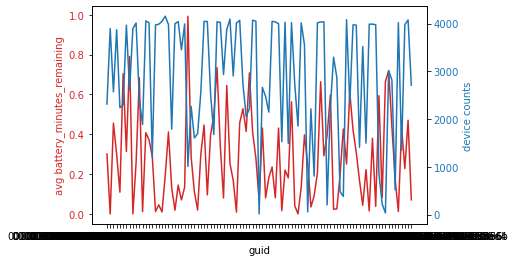

In [13]:
device_cnt = device_use.groupby('guid')['name'].count()
device_cnt = device_cnt[set(needed_battery_event['guid']).intersection(device_use['guid'])]

battery_w_device = needed_battery_event.set_index('guid').loc[set(needed_battery_event['guid']).intersection(device_use['guid'])].reset_index()

data1 = battery_w_device.groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
data2 = device_cnt.sort_index()


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()



The plot above suggests that, there exists some kind of negative association between device counts and average battery remaining minutes for each guid -- more devices, indicating a lower average battery minutes remaining time.

To justify our finding, we used correlation, and indeed find a negative week relationship between battery_min_remaining and number of devices.

In [14]:
np.corrcoef(data1, data2)

array([[ 1.        , -0.08646504],
       [-0.08646504,  1.        ]])

## Second guessing: battery minutes remaining is related with number of processes

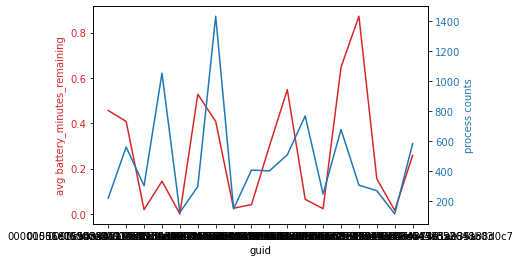

In [15]:
process_cnt = process1.groupby('guid')['proc_name'].count()
process_cnt = process_cnt[set(needed_battery_event['guid']).intersection(process1['guid'])]
battery_w_process = needed_battery_event.set_index('guid').loc[set(needed_battery_event['guid']).intersection(process1['guid'])].reset_index()

data3 = battery_w_process.groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
data4 = process_cnt.sort_index()

fig, ax11 = plt.subplots()
color = 'tab:red'
ax11.set_xlabel('guid')
ax11.set_ylabel('avg battery_minutes_remaining', color=color)
ax11.plot(data3.index, data3, color=color) 
ax11.tick_params(axis='y', labelcolor=color)

ax21 = ax11.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax21.set_ylabel('process counts', color=color)  # we already handled the x-label with ax1
ax21.plot(data3.index, data4, color=color)
ax21.tick_params(axis='y', labelcolor=color)

plt.show()

This time, the plot above also suggests that, there exists some kind of association between process counts and average battery remaining minutes for each guid -- more processes are running, indicating a somewhat higher average battery minutes remaining time.

Again, to justify our finding, we used correlation, and indeed find a positive week relationship between battery_min_remaining and number of processes.

In [16]:
## to check our finding -- using correlation, and find a negative week relationship b/t battery_min_remaining and 
## number of devices.
np.corrcoef(data3, data4)

array([[1.      , 0.198608],
       [0.198608, 1.      ]])

# From previous works

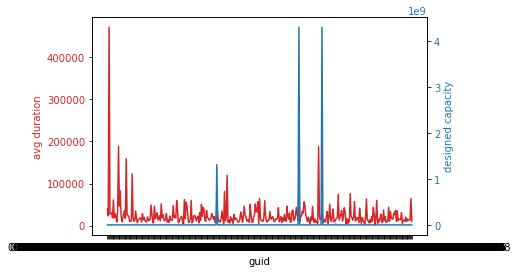

In [17]:
# larger designed capacity would increase the duration of the battery
battery = battery_event.groupby('guid')[['duration']].mean()
merged_battery = battery.merge(battery_info, left_index = True, right_on = 'guid')
sorted_battery = merged_battery.sort_values(by = 'guid').set_index('guid').drop_duplicates('duration')
battery_capacity = merged_battery.groupby('guid')['designed_capacity'].mean()
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg duration', color=color)
ax1.plot(sorted_battery.iloc[1:].index, sorted_battery['duration'].iloc[1:], color=color) 
# need to filter out 1/1/2020, which is the new year, so special day would remain outliers, affect our analysis
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('designed capacity', color=color)  # we already handled the x-label with ax1
ax2.plot(sorted_battery.iloc[1:].index, battery_capacity.iloc[1:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## From this graph, we can see that there is a relatively weak relationship between the average designed capacity 
## and the average duration of a battery
## Reasons for this can be other confouding factors such as the device used and the multiple processes the 
## device is running on 

,battery_minutes_remaining,battery_percent_remaining
battery_minutes_remaining,1.000000,0.087358
battery_percent_remaining,0.087358,1.000000


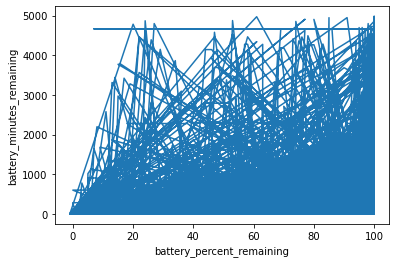

In [18]:
# let's now see whether the battery_percent_remaining correlate with the battery_minutes_remaining

# filter rows who have -1 minute, over 100%, over 5000 minutes
filtered_battery = battery_event[battery_event.battery_minutes_remaining != 1]
filtered_battery = filtered_battery[filtered_battery.battery_minutes_remaining <= 5000]
filtered_battery = filtered_battery[filtered_battery.battery_percent_remaining <= 100]
fig, ax1 = plt.subplots()

ax1.set_xlabel('battery_percent_remaining')
ax1.set_ylabel('battery_minutes_remaining')
ax1.plot(filtered_battery.battery_percent_remaining, filtered_battery.battery_minutes_remaining) 

# the plot seems to overlap a lot
# let's now use the correlation function to check 
condensed_battery = filtered_battery[['battery_minutes_remaining', 'battery_percent_remaining']]
condensed_battery.corr()

## surprisingly, the battery's minutes remaining and the battery's percent remaining has a very low correlation 
## this tells us that we have to be careful which feature we decided to use in the end since this will affect 
## our correlation analysis 

In [19]:
## for simplicity's sake, we will use the battery's percent remaining as our dependent variable 
## let's check whether the system_power_state is correlated with the battery's percent remaining 

# convert system_power_state to numerical values 1 and 0 
powered = battery_event.replace('POWERON', 1).replace('POWEROFF', 0)[['system_power_state', 'battery_minutes_remaining']]
powered.corr()

## once again, whether the system's power state is on or not has little to do with the battery's percent remaining

,system_power_state,battery_minutes_remaining
system_power_state,1.000000,-0.004661
battery_minutes_remaining,-0.004661,1.000000


In [20]:
## let's now check whether the event type is correlated with the battery's percent remaining
event_type = battery_event.replace('AC', 1).replace('DC', 0)[['event_type', 'battery_minutes_remaining']]
event_type.corr()

## unfortunately, there is almost no correlation between the event type used and the battery's percent remaining

,event_type,battery_minutes_remaining
event_type,1.000000,-0.037151
battery_minutes_remaining,-0.037151,1.000000


In [21]:
# let's now check whether the top 2 used devices are correlated with the battery's percent remaining 
filtered_device = device_use[device_use.device.isin(device_use.device.value_counts().iloc[:2].index)]
filtered_device = filtered_device.replace('GUID_DEVINTERFACE_NET', 1).replace('GUID_DEVINTERFACE_HID', 0)[['device', 'guid']]
merged = filtered_device.merge(battery_event[['battery_minutes_remaining', 'guid']], on = 'guid')

merged[['device', 'battery_minutes_remaining']].corr()

## unfortunately, there is almost no correlation between the top 2 devices used and the battery's percent remaining
## at this point, the features we will consider adding to our analysis would be the number of devices, number of 
## processes to predict the battery's percent remaining 
## further EDA may be carried out if necessary 

,device,battery_minutes_remaining
device,1.000000,-0.000844
battery_minutes_remaining,-0.000844,1.000000


In [26]:
# for a third feature, we will add average memory grouped by guid
avg_memory = process1[['guid', 'avg_memory']][process1.guid.isin(X.index)].groupby('guid')['avg_memory'].mean()
avg_memory

guid
00001551e16943a6b157c51db598b7db    16910.934506
000068755b85401f96198ccb667b5154    20319.216570
0000ca3a4b2a4c41accd1ef2f6b3e5b9    19443.554216
0000ce80114e4239a3f62ca6cb618a74    37684.808258
0001cc58cdc14e18aab310cc3e99df33    22817.359248
0001fe5aa404443b808be1bfd3c56a69    21370.533385
0002f3156ece4ff18f7f453d1268e528    30579.904502
Name: avg_memory, dtype: float64

In [27]:
# for a fourth feature, we will add number of runs grouped by guid
num_runs = process1[['guid', 'num_runs']][process1.guid.isin(X.index)].groupby('guid')['num_runs'].mean()
num_runs

guid
00001551e16943a6b157c51db598b7db     5.534247
000068755b85401f96198ccb667b5154     7.675000
0000ca3a4b2a4c41accd1ef2f6b3e5b9    15.375415
0000ce80114e4239a3f62ca6cb618a74     5.603989
0001cc58cdc14e18aab310cc3e99df33     7.722973
0001fe5aa404443b808be1bfd3c56a69    11.740405
0002f3156ece4ff18f7f453d1268e528     9.719212
Name: num_runs, dtype: float64

# Hypothesis Testing

<b>Null Hypothesis</b>: There is no relationship between the battery's minutes remaining and the features of interest 

<b>Alternative Hypothesis</b>: There is some relationship between the battery's minutes remaining and the features of interest 

To test our hypothesis testing, we will get the r-squared of each of our models and compare these numbers to the simulated distribution and check if the p-value is within our threshold of 0.05.

In [28]:
# for our first model selection, we will employ linear regression 
from sklearn.linear_model import LinearRegression
X = pd.concat([data2, data4, avg_memory, num_runs], axis = 1).dropna()
y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
reg = LinearRegression().fit(X, y)
# we get a R^2 of 0.809
obs_val = reg.score(X, y)
obs_val

0.809591580333606

(array([0.21050773, 0.0902176 , 0.51123306, 0.33079786, 0.57137812,
        0.54130559, 0.36087039, 0.81195838, 0.84203092, 0.63152319,
        0.93224851, 1.98478716, 0.90217598, 1.08261118, 1.53369917,
        1.5637717 , 1.53369917, 0.81195838, 1.29311891, 1.4735541 ,
        1.41340904, 2.88696314, 0.69166825, 0.75181332, 0.1804352 ,
        0.93224851, 0.45108799, 0.24058026, 1.86449703, 2.64638288]),
 array([0.00147479, 0.03472773, 0.06798066, 0.1012336 , 0.13448653,
        0.16773947, 0.20099241, 0.23424534, 0.26749828, 0.30075121,
        0.33400415, 0.36725709, 0.40051002, 0.43376296, 0.46701589,
        0.50026883, 0.53352176, 0.5667747 , 0.60002764, 0.63328057,
        0.66653351, 0.69978644, 0.73303938, 0.76629232, 0.79954525,
        0.83279819, 0.86605112, 0.89930406, 0.93255699, 0.96580993,
        0.99906287]),
 <BarContainer object of 30 artists>)

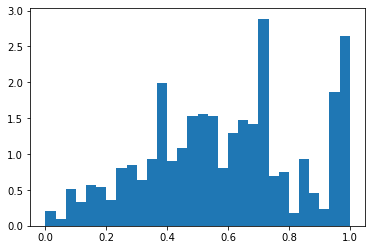

In [29]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution under the assumption 
# that the null hypothesis is true 
scores = []
for _ in range(1000):
    sampled_X = X.sample(replace = True, n = X.shape[0])
    y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
    reg = LinearRegression().fit(sampled_X, y)
    scores.append(reg.score(sampled_X, y))

plt.hist(scores, density=True, bins=30)

In [30]:
p_val = (scores >= obs_val).mean()
p_val 

# with a p-value of 0.2, we fail to reject the null hypothesis, which is that there is no relationship between the 
# battery's minutes remaining and the number of devices, number of processes, average memory, and number of runs 
# thus, we will consider another model for our hypothesis testing 

0.209

In [31]:
# for our second model selection, we will employ lasso regression 
from sklearn.linear_model import Lasso
X = pd.concat([data2, data4, avg_memory, num_runs], axis = 1).dropna()
y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
reg = Lasso(alpha=0.1).fit(X, y)
reg.score(X, y)

0.7763021233285419

(array([0.01735362, 0.03470724, 0.04338404, 0.00867681, 0.06073766,
        0.14750575, 0.08676809, 0.13015213, 0.1908898 , 0.24295065,
        0.36442598, 0.43384045, 0.39913321, 0.43384045, 0.52928535,
        0.52928535, 0.68546791, 0.60737663, 0.50325492, 0.51193173,
        0.56399258, 0.5813462 , 0.43384045, 0.43384045, 0.18221299,
        0.25162746, 0.10412171, 0.10412171, 0.05206085, 0.00867681]),
 array([-2.57454462, -2.45929488, -2.34404514, -2.22879539, -2.11354565,
        -1.99829591, -1.88304616, -1.76779642, -1.65254668, -1.53729693,
        -1.42204719, -1.30679745, -1.19154771, -1.07629796, -0.96104822,
        -0.84579848, -0.73054873, -0.61529899, -0.50004925, -0.38479951,
        -0.26954976, -0.15430002, -0.03905028,  0.07619947,  0.19144921,
         0.30669895,  0.4219487 ,  0.53719844,  0.65244818,  0.76769792,
         0.88294767]),
 <BarContainer object of 30 artists>)

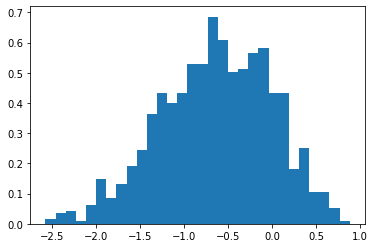

In [32]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution under the assumption 
# that the null hypothesis is true 
lasso_scores = []
for _ in range(1000):
    sampled_X = X.sample(replace = True, n = X.shape[0])
    y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
    reg = Lasso(alpha=0.1).fit(X, y)
    lasso_scores.append(reg.score(sampled_X, y))
    
plt.hist(lasso_scores, density=True, bins=30)

In [33]:
p_val = (lasso_scores >= obs_val).mean()
p_val

# with a p-value of 0.002, we reject the null hypothesis
# this means that there is some relationship between the battery's minutes remaining
# and the number of devices, number of processes, average memory, and number of runs 

0.001

# Improving Model 

In [34]:
# for a fourth feature in replace of number of runs, we will add page faults grouped by guid
page_faults = process1[['guid', 'page_faults']][process1.guid.isin(X.index)].groupby('guid')['page_faults'].mean()
page_faults

guid
00001551e16943a6b157c51db598b7db    2.263944e+05
000068755b85401f96198ccb667b5154    3.448874e+05
0000ca3a4b2a4c41accd1ef2f6b3e5b9    4.737654e+05
0000ce80114e4239a3f62ca6cb618a74    6.168182e+05
0001cc58cdc14e18aab310cc3e99df33    2.997894e+05
0001fe5aa404443b808be1bfd3c56a69    8.889583e+05
0002f3156ece4ff18f7f453d1268e528    1.496412e+06
Name: page_faults, dtype: float64

In [129]:
# for a fifth feature, we will add battery's chemistry composition grouped by guid
from sklearn.preprocessing import OneHotEncoder
chemistry_df = battery_info[['guid', 'chemistry']].dropna()[battery_info.guid.isin(X.index)] \
                                                  .drop_duplicates() \
                                                  .replace('Lion', 'LION')
encoder = OneHotEncoder()
chemistry = pd.DataFrame(encoder.fit_transform(chemistry_df[['chemistry']]).toarray(), columns = ['LION', 'LIP'], 
                                                                                       index = chemistry_df.guid)
chemistry

,LION,LIP
guid,,
0002f3156ece4ff18f7f453d1268e528,1.0,0.0
0000ca3a4b2a4c41accd1ef2f6b3e5b9,1.0,0.0
0001cc58cdc14e18aab310cc3e99df33,0.0,1.0
0001fe5aa404443b808be1bfd3c56a69,1.0,0.0
000068755b85401f96198ccb667b5154,1.0,0.0


In [175]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
X = pd.concat([data2, data4, avg_memory, page_faults, chemistry], axis = 1).dropna()
y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X, y)
dt_val = regressor.score(X, y)
dt_val

1.0

(array([0.0192918 , 0.        , 0.04501419, 0.07073659, 0.0128612 ,
        0.07073659, 0.16719558, 0.19934857, 0.0192918 , 0.18648738,
        0.38583595, 0.23793217, 0.07073659, 0.36654415, 0.70093531,
        0.13504258, 0.27651576, 0.46943374, 0.61733752, 0.10932019,
        0.29580756, 0.83597789, 0.18005678, 0.04501419, 0.12861198,
        0.49515613, 0.05787539, 0.        , 0.0064306 , 0.22507097]),
 array([-3.66521547, -3.50970896, -3.35420246, -3.19869595, -3.04318945,
        -2.88768294, -2.73217644, -2.57666993, -2.42116343, -2.26565692,
        -2.11015042, -1.95464391, -1.79913741, -1.6436309 , -1.4881244 ,
        -1.33261789, -1.17711139, -1.02160488, -0.86609838, -0.71059187,
        -0.55508537, -0.39957886, -0.24407236, -0.08856585,  0.06694065,
         0.22244716,  0.37795366,  0.53346017,  0.68896667,  0.84447318,
         0.99997968]),
 <BarContainer object of 30 artists>)

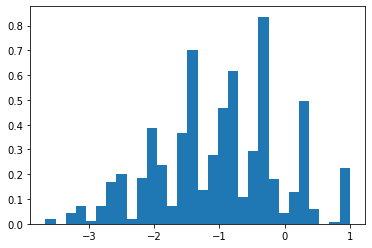

In [176]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution under the assumption 
# that the null hypothesis is true 
dt_scores = []
for _ in range(1000):
    sampled_X = X.sample(replace = True, n = X.shape[0])
    y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(sampled_X, y)
    dt_scores.append(reg.score(sampled_X, y))
    
plt.hist(dt_scores, density=True, bins=30)

In [177]:
p_val = (dt_scores >= dt_val).mean()
p_val

# with a p-value of 0.002, we reject the null hypothesis
# this means that there is some relationship between the battery's minutes remaining
# and the number of devices, number of processes, average memory, page faults, and chemistry composition

0.0

In [178]:
from sklearn import svm
X = pd.concat([data2, data4, avg_memory, page_faults, chemistry], axis = 1).dropna()
y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
regr = svm.SVR()
regr.fit(X, y)
svm_val = regr.score(X, y)
svm_val

0.2178254199721279

(array([0.18270493, 4.32401667, 1.27893451, 1.09622958, 0.82217218,
        1.06577876, 1.40073779, 1.52254108, 0.97442629, 1.21803286,
        1.49209026, 1.33983615, 1.61389354, 0.76127054, 0.82217218,
        0.91352465, 1.43118861, 1.24848369, 2.13155751, 0.66991808,
        0.18270493, 0.03045082, 0.27405739, 0.21315575, 0.18270493,
        0.21315575, 0.66991808, 1.00487711, 0.7003689 , 0.66991808]),
 array([-0.07990245, -0.04706261, -0.01422277,  0.01861706,  0.0514569 ,
         0.08429674,  0.11713657,  0.14997641,  0.18281624,  0.21565608,
         0.24849592,  0.28133575,  0.31417559,  0.34701543,  0.37985526,
         0.4126951 ,  0.44553494,  0.47837477,  0.51121461,  0.54405445,
         0.57689428,  0.60973412,  0.64257395,  0.67541379,  0.70825363,
         0.74109346,  0.7739333 ,  0.80677314,  0.83961297,  0.87245281,
         0.90529265]),
 <BarContainer object of 30 artists>)

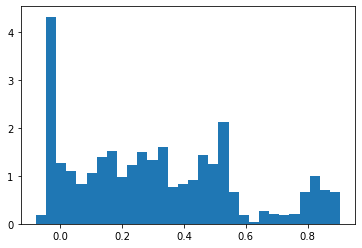

In [179]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution under the assumption 
# that the null hypothesis is true 
svm_scores = []
for _ in range(1000):
    sampled_X = X.sample(replace = True, n = X.shape[0])
    y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
    regr = svm.SVR()
    regr.fit(sampled_X, y)
    svm_scores.append(regr.score(sampled_X, y))
    
plt.hist(svm_scores, density=True, bins=30)

In [180]:
p_val = (svm_scores >= svm_val).mean()
p_val

# with a p-value of 0.002, we reject the null hypothesis
# this means that there is some relationship between the battery's minutes remaining
# and the number of devices, number of processes, average memory, page faults, and chemistry composition

0.582

In [181]:
X = pd.concat([data2, data4, avg_memory, page_faults, chemistry], axis = 1).dropna()
y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
reg = Lasso(alpha=0.1).fit(X, y)
lasso_val = reg.score(X, y)
lasso_val

0.9999867710869096

(array([0.00636227, 0.        , 0.01272453, 0.05089813, 0.04453587,
        0.03181133, 0.15905667, 0.1717812 , 0.03181133, 0.12088307,
        0.39446054, 0.29266427, 0.04453587, 0.47080774, 0.64895121,
        0.17814347, 0.23540387, 0.54079267, 0.66803801, 0.095434  ,
        0.25449067, 0.61713988, 0.286302  , 0.06362267, 0.15905667,
        0.52806814, 0.0381736 , 0.        , 0.01272453, 0.20359254]),
 array([-3.71530709, -3.5581304 , -3.40095372, -3.24377703, -3.08660035,
        -2.92942366, -2.77224698, -2.61507029, -2.4578936 , -2.30071692,
        -2.14354023, -1.98636355, -1.82918686, -1.67201018, -1.51483349,
        -1.35765681, -1.20048012, -1.04330344, -0.88612675, -0.72895007,
        -0.57177338, -0.4145967 , -0.25742001, -0.10024333,  0.05693336,
         0.21411004,  0.37128673,  0.52846341,  0.6856401 ,  0.84281679,
         0.99999347]),
 <BarContainer object of 30 artists>)

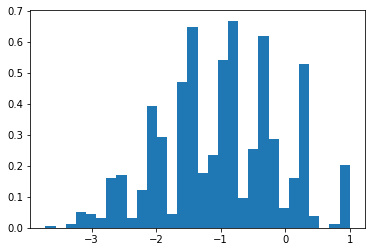

In [182]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution under the assumption 
# that the null hypothesis is true 
lasso_scores = []
for _ in range(1000):
    sampled_X = X.sample(replace = True, n = X.shape[0])
    y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())
    reg = Lasso(alpha=0.1).fit(X, y)
    lasso_scores.append(reg.score(sampled_X, y))
    
plt.hist(lasso_scores, density=True, bins=30)

In [183]:
p_val = (lasso_scores >= lasso_val).mean()
p_val

# with a p-value of 0.002, we reject the null hypothesis
# this means that there is some relationship between the battery's minutes remaining
# and the number of devices, number of processes, average memory, page faults, and chemistry composition

0.001